<a href="https://colab.research.google.com/github/den2morrow/colab_research/blob/main/data_secret_first_cup_2024_v1_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
!pip install lazypredict -q

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from lazypredict.Supervised import LazyClassifier
import seaborn as sns
import torch
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
train_df = pd.read_csv('/content/drive/MyDrive/saved_datasets/Data Secrets First Cup/train_target.csv')
test_df = pd.read_csv('/content/drive/MyDrive/saved_datasets/Data Secrets First Cup/test.csv')
example_submit = pd.read_csv('/content/drive/MyDrive/saved_datasets/Data Secrets First Cup/submit.csv')
orders = pd.read_csv('/content/drive/MyDrive/saved_datasets/Data Secrets First Cup/orders.csv')
mobile_events = pd.read_csv('/content/drive/MyDrive/saved_datasets/Data Secrets First Cup/mobile_events.csv')
clients_promo_october = pd.read_csv('/content/drive/MyDrive/saved_datasets/Data Secrets First Cup/clients_promo_october.csv')

# EDA

## Train EDA
Думаю стоит дополнить датасет информацией из других таблиц, чтобы было больше фич, для рекомендаций

In [ ]:
train_df.head()

,ClientUUId,Id,OrderType,LocalBeginDate,LocalEndDate,OrderPrice,Discount,apply_promo
0,000D3A20F23EA95811E7B99F3ED09FC8,7,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,699,200,0
1,000D3A20F23EA95811E7B99F3ED09FC8,6,"1,2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,1249,25,0
2,000D3A20F23EA95811E7BD373E79565E,5,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,799,200,0
3,000D3A20F23EA95811E7BD373E79565E,5,"1,2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,1249,250,0
4,000D3A20F23EA95811E7BDAE71CD3F33,6,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,699,30,0


In [ ]:
train_df['OrderType'].unique()

array(['2,3', '1,2,3'], dtype=object)

In [ ]:
train_df.shape, train_df[train_df['apply_promo'] == 1].shape

((27741, 8), (827, 8))

In [ ]:
test_df['LocalBeginDate'].unique(), test_df['LocalEndDate'].unique()

(array(['2023-11-02T00:00:00Z'], dtype=object),
 array(['2023-11-05T23:59:00Z'], dtype=object))

In [ ]:
train_df['LocalBeginDate'].unique(), train_df['LocalEndDate'].unique()

(array(['2023-11-02T00:00:00.000Z'], dtype=object),
 array(['2023-11-05T23:59:00.000Z'], dtype=object))

Text(0.5, 1.0, 'Correlation matrix')

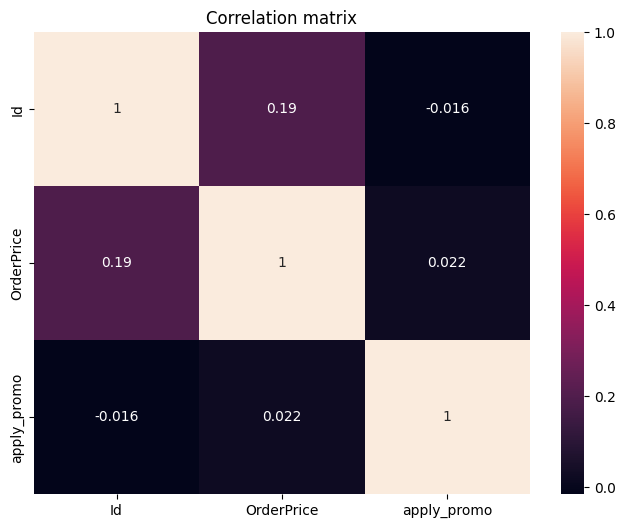

In [ ]:
# Есть ли линейная корреляция с ценой заказа и промо / типом скидки и промо?
corr_matrix = train_df[['Id', 'OrderPrice', 'apply_promo']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation matrix') # Вроде нет линейной корреляции

In [ ]:
# А какое кол-во применных промокодов в зависимости от типа скидки (рубли, проценты, коины)?
[train_df[(train_df['Id'] == i) & (train_df['apply_promo'] == 1)].shape[0] for i in range(5, 8)]

[289, 239, 299]

## Test EDA
Буду проверять на данном датасете

In [ ]:
test_df.head()

,ClientUUId,Id,OrderType,LocalBeginDate,LocalEndDate,OrderPrice,Discount
0,000D3A20F23EA95811E7C0A95563344E,7,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,799,200
1,000D3A20F23EA95811E7C7892A0CE261,5,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,699,200
2,000D3A20F23EA95811E7CD686C396528,6,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,799,20
3,000D3A20F23EA95911E7CEA8C574EDAE,5,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,799,200
4,000D3A20F23EA95911E7D4F05C59C978,7,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,799,200


In [ ]:
test_df.shape

(6806, 7)

## Example submit check
Просто как оформить сабмит

In [ ]:
example_submit.head()

,apply_promo
0,0.307216
1,0.917305
2,0.386569
3,0.542179
4,0.536205


## Orders EDA
Таблица заказов позволяет понять, какие пользователи были, какие нет, и какие у них прошлые привычки при заказах

In [ ]:
orders.head()

,OrderUUId,addressId,deliverySectorId,ClientUUId,Date,SaleDate,UnitUUId,NewClient,ClientOrderNumber,ProductUUId,CategoryId,ProductTotalPrice,MenuPrice,OrderState,OrderPaymentType,OrderTotalPrice,OrderType,apply_promo
0,020DD76CCD949AE011EDE031ED5D76FD,NaN,NaN,000D3AAC9DCABB2E11EBE0614C89D044,2023-04-21,2023-04-21T20:51:26.000Z,000D3A2480C380DA11E692CFB9F92484,0,18,000D3A240C71BE9A11E719BE2AB264A6,4,1.0,45.0,4,2,1.0,3,0
1,02164D9B0F67BC3311EE610987AF48C7,0.0,0.0,000D3A21DA51A81411EAF10674007D74,2023-10-02,2023-10-02T21:31:32.000Z,000D3A26B5B080DF11E745FD0474B95C,0,29,11EC9AABAD354BE051CCF1EE1F83A8D0,1,485.0,485.0,4,2,1164.0,1,0
2,02164D9B0F67BC3311EE610987AF48C7,0.0,0.0,000D3A21DA51A81411EAF10674007D74,2023-10-02,2023-10-02T21:31:32.000Z,000D3A26B5B080DF11E745FD0474B95C,0,29,11EB846583CB3BDEA80D1A7F2E184D40,1,589.0,589.0,4,2,1164.0,1,0
3,02164D9B0F67BC3311EE610987AF48C7,0.0,0.0,000D3A21DA51A81411EAF10674007D74,2023-10-02,2023-10-02T21:31:32.000Z,000D3A26B5B080DF11E745FD0474B95C,0,29,000D3A240C71BE9A11E719BE2AB267FD,4,45.0,45.0,4,2,1164.0,1,0
4,02164D9B0F67BC3311EE610987AF48C7,0.0,0.0,000D3A21DA51A81411EAF10674007D74,2023-10-02,2023-10-02T21:31:32.000Z,000D3A26B5B080DF11E745FD0474B95C,0,29,000D3A240C71BE9A11E719BE2AB264A6,4,45.0,45.0,4,2,1164.0,1,0


In [ ]:
orders.shape

(611739, 18)

In [ ]:
len(orders['ClientUUId'].unique())

16337

In [ ]:
orders[(orders['NewClient']  == 1) & (orders['ClientOrderNumber'] > 1)].head()

,OrderUUId,addressId,deliverySectorId,ClientUUId,Date,SaleDate,UnitUUId,NewClient,ClientOrderNumber,ProductUUId,CategoryId,ProductTotalPrice,MenuPrice,OrderState,OrderPaymentType,OrderTotalPrice,OrderType,apply_promo


In [ ]:
orders[(orders['ClientUUId'].isin(orders[orders['NewClient'] == 0])) & (orders['NewClient'] == 1)]

,OrderUUId,addressId,deliverySectorId,ClientUUId,Date,SaleDate,UnitUUId,NewClient,ClientOrderNumber,ProductUUId,CategoryId,ProductTotalPrice,MenuPrice,OrderState,OrderPaymentType,OrderTotalPrice,OrderType,apply_promo


## Mobile Events EDA
На данный момент не могу придумать, как можно было бы использовать эту таблицу

In [ ]:
mobile_events.head()

,ClientUUId,VisitToken,EventName,Platform,Timestamp
0,000D3A22FA54A81611EB315CF5443815,976627AD-76DC-41D9-981E-F2A6CA14B3A9,screen_menu,ios,2023-10-29T16:14:21.343Z
1,2A4A64AF719E994511EE3F2D8B31E188,5b22e610-c71e-4b6a-a842-71e8575ece87,screen_menu,android,2023-10-29T11:04:36.4840000Z
2,000D3AAC977BBB2F11ECDD081F5481AE,BDCEB72F-2B6A-4565-801A-6CB729279C6F,open_app,ios,2023-10-29T11:14:34.723Z
3,000D3A21DA51A81411EAE468856F96F1,A66E2DA6-4E2E-4C37-9FBF-627732623212,add_to_cart,ios,2023-10-29T14:03:08.363Z
4,000D3A23B0DC80D811E67F4D0A9CA345,1BE8139F-A3D3-439F-A51B-5CBD4D3FFF1B,screen_menu,ios,2023-10-29T08:35:40.127Z


In [ ]:
mobile_events.shape

(3916654, 5)

In [ ]:
len(mobile_events['VisitToken'].unique())  # То есть есть одинаковые токены посещения?

223964

## Clients promo october EDA
Таблица позволит понять, какие промокоды интересны пользователям (так как здесь уже выданные и использованные промокоды)

Возможно, LocalBeginDate ~ orders['SaleDate'] или LocalEndDate ~ orders['SaleDate']

Если это так, то можно будет собрать более интересные фичи, объединив две таблицы

In [ ]:
clients_promo_october.head()  # Id - 5=рубли, 6=проценты, 7=додокоины

,ClientUUId,Id,LocalBeginDate,LocalEndDate,OrderType,OrderPrice,Discount
0,000D3A20F23EA95811E7B7104AC23CD3,6,2023-10-12T00:00:00.000Z,2023-10-15T23:59:00.000Z,"1,2,3",1299,25
1,000D3A20F23EA95811E7B7D79FAABAA1,5,2023-10-12T00:00:00.000Z,2023-10-15T23:59:00.000Z,"1,2,3",1299,300
2,000D3A20F23EA95811E7B8BD71C73877,7,2023-10-12T00:00:00.000Z,2023-10-15T23:59:00.000Z,"1,2,3",1249,200
3,000D3A20F23EA95811E7B99F3ED09FC8,6,2023-10-12T00:00:00.000Z,2023-10-15T23:59:00.000Z,"1,2,3",1249,30
4,000D3A20F23EA95811E7BD373E79565E,6,2023-10-12T00:00:00.000Z,2023-10-15T23:59:00.000Z,"1,2,3",1299,20


In [ ]:
clients_promo_october.shape

(477275, 7)

In [ ]:
clients_promo_october[['Id', 'OrderPrice', 'Discount']].corr()

,Id,OrderPrice,Discount
Id,1.00,0.30,-0.05
OrderPrice,0.30,1.00,0.39
Discount,-0.05,0.39,1.00


(0.3216531349850715, 0.4686690063380651, 0.20967785867686345)

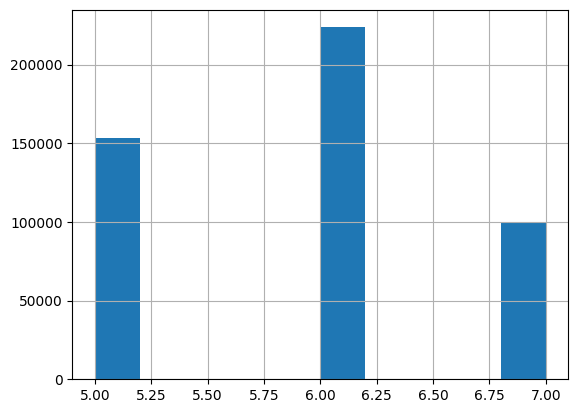

In [ ]:
clients_promo_october['Id'].hist()

In [ ]:
(clients_promo_october['Discount'] / clients_promo_october['OrderPrice']).describe()

count   477275.00
mean         0.12
std          0.10
min          0.01
25%          0.03
50%          0.16
75%          0.21
max          0.35
dtype: float64

<Axes: >

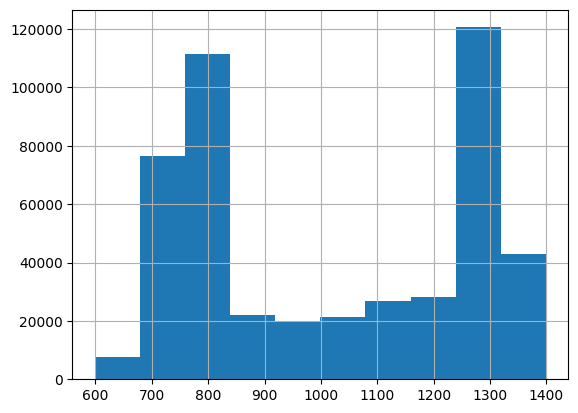

In [ ]:
clients_promo_october['OrderPrice'].hist()

<Axes: >

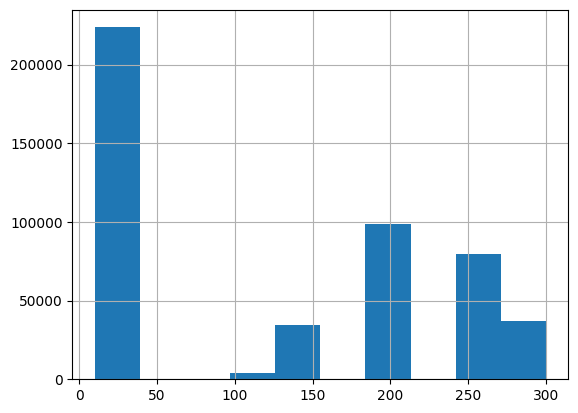

In [ ]:
clients_promo_october['Discount'].hist()

<Axes: >

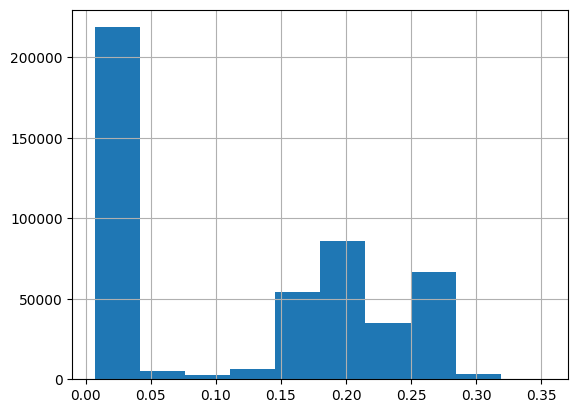

In [ ]:
(clients_promo_october['Discount'] / clients_promo_october['OrderPrice']).hist()

# Создание новых признаков (эксперементирую)

## Из таблицы Orders

In [ ]:
# NewClient, ClientOrderNumber, Сколько раз использовал промокоды(ClientCountPromo), процент покупок с промокодами (PercentWithPromo)
# Процент промокодов на каждый тип OrderType
# ProductTotalPrice(цена со скидкой) и MenuPrice(обычная цена), т.е. Discount=MenuPrice-ProductTotalPrice в train_df есть схожее Discount
# Нужно будет еще глянуть на OrderPrice (порог срабатывания, так как думаю это будет влиять на использование промокодов)

In [ ]:
# is_new_client = orders.groupby('ClientUUId')['NewClient'].min().reset_index(name='NewClient')
# client_order_features = client_order_features.merge(is_new_client, on='ClientUUId', how='left')
# client_order_features['Discount'] = Пока оставим так, скидка точно влияет, но пока я не могу придумать, какая именно должна быть фича, для работы со скидками

In [ ]:
orders['Discount'] = orders['MenuPrice'] - orders['ProductTotalPrice']

In [ ]:
# Количество использованных промо
client_count_promo = orders.groupby('ClientUUId')['apply_promo'].sum().reset_index(name='client_count_promo')

# Количество заказов клиента
client_order_counts = orders.groupby('ClientUUId')['OrderUUId'].count().reset_index(name='client_order_count')

# Средняя сумма заказа клиента
client_avg_order_price = orders.groupby('ClientUUId')['OrderTotalPrice'].mean().reset_index(name='client_avg_order_price')

# События клиента
client_event_counts = mobile_events.groupby('ClientUUId')['EventName'].count().reset_index(name='client_event_count')

In [ ]:
client_order_features = client_count_promo.merge(client_order_counts, on='ClientUUId', how='left')
client_order_features = client_order_features.merge(client_avg_order_price, on='ClientUUId', how='left')
client_order_features = client_order_features.merge(client_event_counts, on='ClientUUId', how='left')

client_order_features['percent_order_with_promo'] = client_order_features['client_count_promo'] / client_order_features['client_order_count']


In [ ]:
client_order_features.head()

,ClientUUId,client_count_promo,client_order_count,client_avg_order_price,client_event_count,percent_order_with_promo
0,000D3A20F23EA95811E7B7104AC23CD3,62,74,1139.81,127.00,0.84
1,000D3A20F23EA95811E7B88F5E50100B,6,52,1150.29,210.00,0.12
2,000D3A20F23EA95811E7B8BD71C73877,5,35,945.60,124.00,0.14
3,000D3A20F23EA95811E7B95FE7E6321C,5,48,904.23,52.00,0.10
4,000D3A20F23EA95811E7B969B5BD2C3F,0,34,1170.53,120.00,0.00


In [ ]:
client_order_features.isnull().sum()

ClientUUId                   0
client_count_promo           0
client_order_count           0
client_avg_order_price       0
client_event_count          86
percent_order_with_promo     0
dtype: int64

In [ ]:
client_order_features['client_event_count'] = client_order_features['client_event_count'].fillna(0)

In [ ]:
client_order_features.columns

Index(['ClientUUId', 'client_count_promo', 'client_order_count',
       'client_avg_order_price', 'client_event_count',
       'percent_order_with_promo'],
      dtype='object')

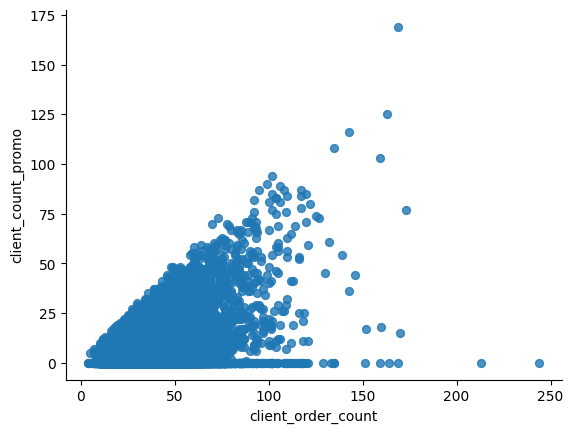

In [ ]:
# @title client_count_promo vs client_order_count

from matplotlib import pyplot as plt
client_order_features.plot(kind='scatter', x='client_order_count', y='client_count_promo', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

## Из таблицы Clients Promo October

Для создания новых фич могут быть интересны Discount (размер скидки), OrderPrice (порог срабатывания), Id (рубли/проценты/додокоины), OrderType (тип заказа)

In [ ]:
# Делаю копию, чтобы на ней и создавать новые фичи этой таблицы
promo_features = clients_promo_october.copy()

# Отношение скидки к порогу срабатывания
promo_features['discount_to_orderprice_ratio'] = promo_features['Discount'] / promo_features['OrderPrice']

# Средний размер скидки для клиента
avg_discount_per_client = promo_features.groupby('ClientUUId')['Discount'].mean().reset_index(name='avg_discount_per_client')
avg_discount_per_client.columns = ['ClientUUId', 'avg_discount_per_client']
promo_features = promo_features.merge(avg_discount_per_client, on='ClientUUId', how='left')

# Общее количество промо-акций для клиента
total_promos_per_client = promo_features.groupby('ClientUUId')['Id'].count().reset_index(name='total_promos')
total_promos_per_client.columns = ['ClientUUId', 'total_promos']
promo_features = promo_features.merge(total_promos_per_client, on='ClientUUId', how='left')

# Скидка по типу заказа
discount_by_order_type = promo_features.groupby('OrderType')['Discount'].mean().reset_index(name='mean_discount_by_type')
discount_by_order_type.columns = ['OrderType', 'mean_discount_by_type']
promo_features = promo_features.merge(discount_by_order_type, on='OrderType', how='left')

# Порог срабатывания по типу заказа
orderprice_by_order_type = promo_features.groupby('OrderType')['OrderPrice'].mean().reset_index(name='mean_orderprice_by_type')
orderprice_by_order_type.columns = ['OrderType', 'mean_orderprice_by_type']
promo_features = promo_features.merge(orderprice_by_order_type, on='OrderType', how='left')


# Ids = [clients_promo_october[clients_promo_october['Id'] == i]['Id'].count() for i in range(5, 8)]
# id_5_percent, id_6_percent, id_7_percent = Ids[0]/sum(Ids), Ids[1]/sum(Ids), Ids[2]/sum(Ids)
# id_5_percent, id_6_percent, id_7_percent

In [ ]:
# # Словарь для замены значений
# replace_dict = {
#     5: id_5_percent,
#     6: id_6_percent,
#     7: id_7_percent
# }

# # Замена значений в колонке 'Id'
# new_clients_promo_october['percent_of_id'] = new_clients_promo_october['Id'].map(replace_dict)
# new_clients_promo_october.head()
promo_features.head()

,ClientUUId,Id,LocalBeginDate,LocalEndDate,OrderType,OrderPrice,Discount,discount_to_orderprice_ratio,avg_discount_per_client,total_promos,mean_discount_by_type,mean_orderprice_by_type
0,000D3A20F23EA95811E7B7104AC23CD3,6,2023-10-12T00:00:00.000Z,2023-10-15T23:59:00.000Z,"1,2,3",1299,25,0.02,107.86,14,154.68,1220.01
1,000D3A20F23EA95811E7B7D79FAABAA1,5,2023-10-12T00:00:00.000Z,2023-10-15T23:59:00.000Z,"1,2,3",1299,300,0.23,227.22,18,154.68,1220.01
2,000D3A20F23EA95811E7B8BD71C73877,7,2023-10-12T00:00:00.000Z,2023-10-15T23:59:00.000Z,"1,2,3",1249,200,0.16,145.00,16,154.68,1220.01
3,000D3A20F23EA95811E7B99F3ED09FC8,6,2023-10-12T00:00:00.000Z,2023-10-15T23:59:00.000Z,"1,2,3",1249,30,0.02,80.36,14,154.68,1220.01
4,000D3A20F23EA95811E7BD373E79565E,6,2023-10-12T00:00:00.000Z,2023-10-15T23:59:00.000Z,"1,2,3",1299,20,0.02,94.58,12,154.68,1220.01


In [ ]:
promo_features = promo_features[['ClientUUId', 'discount_to_orderprice_ratio', 'avg_discount_per_client',
                                 'total_promos', 'mean_discount_by_type', 'mean_orderprice_by_type']]

In [ ]:
promo_features.head()

,ClientUUId,discount_to_orderprice_ratio,avg_discount_per_client,total_promos,mean_discount_by_type,mean_orderprice_by_type
0,000D3A20F23EA95811E7B7104AC23CD3,0.02,107.86,14,154.68,1220.01
1,000D3A20F23EA95811E7B7D79FAABAA1,0.23,227.22,18,154.68,1220.01
2,000D3A20F23EA95811E7B8BD71C73877,0.16,145.00,16,154.68,1220.01
3,000D3A20F23EA95811E7B99F3ED09FC8,0.02,80.36,14,154.68,1220.01
4,000D3A20F23EA95811E7BD373E79565E,0.02,94.58,12,154.68,1220.01


Когда буду делать модель с нейронной сетью, нужно будет нормализовывать фичи, перед передачей в модель

# Merge data (last preprocess)

## Merge data with train (last preprocess)

In [ ]:
# Присоединение новых признаков к основному DataFrame
new_train_df = train_df.merge(client_order_features, on='ClientUUId', how='left')
new_train_df = new_train_df.merge(promo_features, on='ClientUUId', how='left')

In [ ]:
new_train_df.isnull().sum(), new_train_df.shape[0]

(ClientUUId                      0
 Id                              0
 OrderType                       0
 LocalBeginDate                  0
 LocalEndDate                    0
 OrderPrice                      0
 Discount                        0
 apply_promo                     0
 client_count_promo          12721
 client_order_count          12721
 client_avg_order_price      12721
 client_event_count          12721
 percent_order_with_promo    12721
 avg_discount_per_client         0
 total_promos                    0
 dtype: int64,
 27741)

In [ ]:
new_train_df['client_count_promo'] = new_train_df['client_count_promo'].fillna(0)
new_train_df['client_order_count'] = new_train_df['client_order_count'].fillna(0)
new_train_df['client_avg_order_price'] = new_train_df['client_avg_order_price'].fillna(0)
new_train_df['client_event_count'] = new_train_df['client_event_count'].fillna(0)
new_train_df['percent_order_with_promo'] = new_train_df['percent_order_with_promo'].fillna(0)

In [ ]:
new_train_df.isnull().sum(), new_train_df.shape[0]

(ClientUUId                  0
 Id                          0
 OrderType                   0
 LocalBeginDate              0
 LocalEndDate                0
 OrderPrice                  0
 Discount                    0
 apply_promo                 0
 client_count_promo          0
 client_order_count          0
 client_avg_order_price      0
 client_event_count          0
 percent_order_with_promo    0
 avg_discount_per_client     0
 total_promos                0
 dtype: int64,
 27741)

In [ ]:
new_train_df.head()

,ClientUUId,Id,OrderType,LocalBeginDate,LocalEndDate,OrderPrice,Discount,apply_promo,client_count_promo,client_order_count,client_avg_order_price,client_event_count,percent_order_with_promo,discount_to_orderprice_ratio,avg_discount_per_client,total_promos,mean_discount_by_type,mean_orderprice_by_type
0,000D3A20F23EA95811E7B99F3ED09FC8,7,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,699,200,0,0.00,33.00,1853.73,187.00,0.00,0.02,80.36,14,154.68,1220.01
1,000D3A20F23EA95811E7B99F3ED09FC8,7,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,699,200,0,0.00,33.00,1853.73,187.00,0.00,0.20,80.36,14,100.73,816.43
2,000D3A20F23EA95811E7B99F3ED09FC8,7,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,699,200,0,0.00,33.00,1853.73,187.00,0.00,0.02,80.36,14,154.68,1220.01
3,000D3A20F23EA95811E7B99F3ED09FC8,7,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,699,200,0,0.00,33.00,1853.73,187.00,0.00,0.02,80.36,14,154.68,1220.01
4,000D3A20F23EA95811E7B99F3ED09FC8,7,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,699,200,0,0.00,33.00,1853.73,187.00,0.00,0.02,80.36,14,154.68,1220.01


In [ ]:
new_train_df['OrderType'].unique(), new_train_df['Id'].unique()

(array(['2,3', '1,2,3'], dtype=object), array([7, 6, 5]))

In [ ]:
new_train_df[new_train_df['Id'] == 5]

,ClientUUId,Id,OrderType,LocalBeginDate,LocalEndDate,OrderPrice,Discount,apply_promo,client_count_promo,client_order_count,client_avg_order_price,client_event_count,percent_order_with_promo,discount_to_orderprice_ratio,avg_discount_per_client,total_promos,mean_discount_by_type,mean_orderprice_by_type
28,000D3A20F23EA95811E7BD373E79565E,5,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,799,200,0,0.00,0.00,0.00,0.00,0.00,0.02,94.58,12,154.68,1220.01
29,000D3A20F23EA95811E7BD373E79565E,5,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,799,200,0,0.00,0.00,0.00,0.00,0.00,0.03,94.58,12,100.73,816.43
30,000D3A20F23EA95811E7BD373E79565E,5,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,799,200,0,0.00,0.00,0.00,0.00,0.00,0.02,94.58,12,154.68,1220.01
31,000D3A20F23EA95811E7BD373E79565E,5,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,799,200,0,0.00,0.00,0.00,0.00,0.00,0.04,94.58,12,100.73,816.43
32,000D3A20F23EA95811E7BD373E79565E,5,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,799,200,0,0.00,0.00,0.00,0.00,0.00,0.02,94.58,12,154.68,1220.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441134,8606F5E4CA39BF7211EE517E6E1D90B7,5,"1,2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,1249,250,0,0.00,0.00,0.00,0.00,0.00,0.02,129.44,18,154.68,1220.01
441135,8606F5E4CA39BF7211EE517E6E1D90B7,5,"1,2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,1249,250,0,0.00,0.00,0.00,0.00,0.00,0.20,129.44,18,154.68,1220.01
441136,8606F5E4CA39BF7211EE517E6E1D90B7,5,"1,2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,1249,250,0,0.00,0.00,0.00,0.00,0.00,0.03,129.44,18,100.73,816.43
441137,8606F5E4CA39BF7211EE517E6E1D90B7,5,"1,2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,1249,250,0,0.00,0.00,0.00,0.00,0.00,0.04,129.44,18,100.73,816.43


In [ ]:
# Обработка категориальных признаков
new_train_df = pd.get_dummies(new_train_df, columns=['Id'], prefix='Id')

In [ ]:
new_train_df.head()

,ClientUUId,OrderType,LocalBeginDate,LocalEndDate,OrderPrice,Discount,apply_promo,client_count_promo,client_order_count,client_avg_order_price,client_event_count,percent_order_with_promo,discount_to_orderprice_ratio,avg_discount_per_client,total_promos,mean_discount_by_type,mean_orderprice_by_type,Id_5,Id_6,Id_7
0,000D3A20F23EA95811E7B99F3ED09FC8,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,699,200,0,0.00,33.00,1853.73,187.00,0.00,0.02,80.36,14,154.68,1220.01,False,False,True
1,000D3A20F23EA95811E7B99F3ED09FC8,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,699,200,0,0.00,33.00,1853.73,187.00,0.00,0.20,80.36,14,100.73,816.43,False,False,True
2,000D3A20F23EA95811E7B99F3ED09FC8,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,699,200,0,0.00,33.00,1853.73,187.00,0.00,0.02,80.36,14,154.68,1220.01,False,False,True
3,000D3A20F23EA95811E7B99F3ED09FC8,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,699,200,0,0.00,33.00,1853.73,187.00,0.00,0.02,80.36,14,154.68,1220.01,False,False,True
4,000D3A20F23EA95811E7B99F3ED09FC8,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,699,200,0,0.00,33.00,1853.73,187.00,0.00,0.02,80.36,14,154.68,1220.01,False,False,True


In [ ]:
new_train_df['LocalEndDate'].unique(), new_train_df['LocalBeginDate'].unique()

(array(['2023-11-05T23:59:00.000Z'], dtype=object),
 array(['2023-11-02T00:00:00.000Z'], dtype=object))

In [ ]:
new_train_df['LocalEndDate'] = pd.to_datetime(new_train_df['LocalEndDate'], format="%Y-%m-%dT%H:%M:%S.%fZ")
new_train_df['LocalBeginDate'] = pd.to_datetime(new_train_df['LocalBeginDate'], format="%Y-%m-%dT%H:%M:%S.%fZ")

(new_train_df['LocalEndDate'] - new_train_df['LocalBeginDate']).unique()

<TimedeltaArray>
['3 days 23:59:00']
Length: 1, dtype: timedelta64[ns]

In [ ]:
# Подготовка данных для модели
X = new_train_df.drop(columns=['apply_promo', 'LocalBeginDate', 'LocalEndDate', 'OrderType', 'ClientUUId'])  # OrderType пока убираю, так как не знаю, как кодировать его пока, а ClientUUId потому что это id, который и так есть в таблице
y = new_train_df['apply_promo']

In [ ]:
X.columns

Index(['OrderPrice', 'Discount', 'client_count_promo', 'client_order_count',
       'client_avg_order_price', 'client_event_count',
       'percent_order_with_promo', 'discount_to_orderprice_ratio',
       'avg_discount_per_client', 'total_promos', 'mean_discount_by_type',
       'mean_orderprice_by_type', 'Id_5', 'Id_6', 'Id_7'],
      dtype='object')

In [ ]:
# Разделение данных на тренировочную и тестовую выборки
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

## Merge data with test (last preprocess)

In [ ]:
# Присоединение новых признаков к основному DataFrame
new_test_df = test_df.merge(client_order_features, on='ClientUUId', how='left')
new_test_df = new_test_df.merge(promo_features, on='ClientUUId', how='left')


# Заполнение пустых значений
new_test_df['client_count_promo'] = new_test_df['client_count_promo'].fillna(0)
new_test_df['client_order_count'] = new_test_df['client_order_count'].fillna(0)
new_test_df['client_avg_order_price'] = new_test_df['client_avg_order_price'].fillna(0)
new_test_df['client_event_count'] = new_test_df['client_event_count'].fillna(0)
new_test_df['percent_order_with_promo'] = new_test_df['percent_order_with_promo'].fillna(0)

# Обработка категориальных признаков
new_test_df = pd.get_dummies(new_test_df, columns=['Id'], prefix='Id')

X_test = new_test_df.drop(columns=['LocalBeginDate', 'LocalEndDate', 'OrderType', 'ClientUUId'])  # OrderType пока убираю, так как не знаю, как кодировать его пока, а ClientUUId потому что это id, который и так есть в таблице

In [ ]:
X_test.head()

,OrderPrice,Discount,client_count_promo,client_order_count,client_avg_order_price,client_event_count,percent_order_with_promo,discount_to_orderprice_ratio,avg_discount_per_client,total_promos,mean_discount_by_type,mean_orderprice_by_type,Id_5,Id_6,Id_7
0,799,200,2.00,30.00,569.03,107.00,0.07,0.18,99.17,12,154.68,1220.01,False,False,True
1,799,200,2.00,30.00,569.03,107.00,0.07,0.02,99.17,12,154.68,1220.01,False,False,True
2,799,200,2.00,30.00,569.03,107.00,0.07,0.15,99.17,12,154.68,1220.01,False,False,True
3,799,200,2.00,30.00,569.03,107.00,0.07,0.14,99.17,12,154.68,1220.01,False,False,True
4,799,200,2.00,30.00,569.03,107.00,0.07,0.25,99.17,12,100.73,816.43,False,False,True


In [ ]:
X_train.head()

,OrderPrice,Discount,client_count_promo,client_order_count,client_avg_order_price,client_event_count,percent_order_with_promo,discount_to_orderprice_ratio,avg_discount_per_client,total_promos,mean_discount_by_type,mean_orderprice_by_type,Id_5,Id_6,Id_7
247318,599,150,0.00,41.00,413.71,68.00,0.00,0.02,107.19,16,100.73,816.43,False,False,True
336974,1149,25,0.00,0.00,0.00,0.00,0.00,0.20,112.50,12,154.68,1220.01,False,True,False
18993,699,200,0.00,0.00,0.00,0.00,0.00,0.04,140.28,18,100.73,816.43,True,False,False
40327,799,200,0.00,0.00,0.00,0.00,0.00,0.25,98.75,12,100.73,816.43,True,False,False
343039,799,200,0.00,0.00,0.00,0.00,0.00,0.18,121.11,18,154.68,1220.01,True,False,False


# Inference

# Preprocess pipeline

In [98]:
######################## Orders #######################################

orders['Discount'] = orders['MenuPrice'] - orders['ProductTotalPrice']

# Количество использованных промо
client_count_promo = orders.groupby('ClientUUId')['apply_promo'].sum().reset_index(name='client_count_promo')

# Количество заказов клиента
client_order_counts = orders.groupby('ClientUUId')['OrderUUId'].count().reset_index(name='client_order_count')

# Средняя сумма заказа клиента
client_avg_order_price = orders.groupby('ClientUUId')['OrderTotalPrice'].mean().reset_index(name='client_avg_order_price')

# События клиента
client_event_counts = mobile_events.groupby('ClientUUId')['EventName'].count().reset_index(name='client_event_count')


# Объединение с новыми признаками
client_order_features = client_count_promo.merge(client_order_counts, on='ClientUUId', how='left')
client_order_features = client_order_features.merge(client_avg_order_price, on='ClientUUId', how='left')
client_order_features = client_order_features.merge(client_event_counts, on='ClientUUId', how='left')

client_order_features['percent_order_with_promo'] = client_order_features['client_count_promo'] / client_order_features['client_order_count']

# Заполнение пустых значений
client_order_features['client_event_count'] = client_order_features['client_event_count'].fillna(0)

######################## Client Promo October #######################################


# Делаю копию, чтобы на ней и создавать новые фичи этой таблицы
promo_features = clients_promo_october.copy()

# Отношение скидки к порогу срабатывания
# promo_features['discount_to_orderprice_ratio'] = promo_features['Discount'] / promo_features['OrderPrice']

# Средний размер скидки для клиента
avg_discount_per_client = promo_features.groupby('ClientUUId')['Discount'].mean().reset_index(name='avg_discount_per_client')
avg_discount_per_client.columns = ['ClientUUId', 'avg_discount_per_client']


# Общее количество промо-акций для клиента
total_promos_per_client = promo_features.groupby('ClientUUId')['Id'].count().reset_index(name='total_promos')

# Скидка по типу заказа
discount_by_order_type = promo_features.groupby('OrderType')['Discount'].mean().reset_index(name='mean_discount_by_type')

# Порог срабатывания по типу заказа
orderprice_by_order_type = promo_features.groupby('OrderType')['OrderPrice'].mean().reset_index(name='mean_orderprice_by_type')


promo_features = avg_discount_per_client.merge(total_promos_per_client, on='ClientUUId', how='left')
# promo_features = promo_features.merge(discount_by_order_type, on='OrderType', how='left')
# promo_features = promo_features.merge(orderprice_by_order_type, on='OrderType', how='left')

promo_features = promo_features[['ClientUUId', 'avg_discount_per_client',
                                 'total_promos']]  # 'mean_discount_by_type', 'mean_orderprice_by_type', 'discount_to_orderprice_ratio'
promo_features.shape

(30000, 3)

In [99]:
################################## Merge Train ####################################################

# Присоединение новых признаков к основному test DataFrame
new_train_df = train_df.merge(client_order_features, on='ClientUUId', how='left')
new_train_df = new_train_df.merge(promo_features, on='ClientUUId', how='left')

# Заполнение пустых значений
new_train_df['client_count_promo'] = new_train_df['client_count_promo'].fillna(0)
new_train_df['client_order_count'] = new_train_df['client_order_count'].fillna(0)
new_train_df['client_avg_order_price'] = new_train_df['client_avg_order_price'].fillna(0)
new_train_df['client_event_count'] = new_train_df['client_event_count'].fillna(0)
new_train_df['percent_order_with_promo'] = new_train_df['percent_order_with_promo'].fillna(0)

# Обработка категориальных признаков
new_train_df = pd.get_dummies(new_train_df, columns=['Id'], prefix='Id')

# Удаление столбцов
X_train_main = new_train_df.drop(columns=['apply_promo', 'OrderType', 'ClientUUId', 'LocalBeginDate', 'LocalEndDate'])  # OrderType пока убираю, так как не знаю, как кодировать его пока, а ClientUUId потому что это id, который и так есть в таблице
y_train_main = new_train_df['apply_promo']


X_train, X_val, y_train, y_val = train_test_split(X_train_main, y_train_main, test_size=0.2, random_state=42, shuffle=True)

In [100]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((22192, 12), (22192,), (5549, 12), (5549,))

In [101]:
############################### Merge Test ########################################################

# Присоединение новых признаков к основному test DataFrame
new_test_df = test_df.merge(client_order_features, on='ClientUUId', how='left')
new_test_df = new_test_df.merge(promo_features, on='ClientUUId', how='left')

# Заполнение пустых значений
new_test_df['client_count_promo'] = new_test_df['client_count_promo'].fillna(0)
new_test_df['client_order_count'] = new_test_df['client_order_count'].fillna(0)
new_test_df['client_avg_order_price'] = new_test_df['client_avg_order_price'].fillna(0)
new_test_df['client_event_count'] = new_test_df['client_event_count'].fillna(0)
new_test_df['percent_order_with_promo'] = new_test_df['percent_order_with_promo'].fillna(0)

# Обработка категориальных признаков
new_test_df = pd.get_dummies(new_test_df, columns=['Id'], prefix='Id')

# Удаление столбцов
X_test = new_test_df.drop(columns=['OrderType', 'ClientUUId', 'LocalBeginDate', 'LocalEndDate'])  # OrderType пока убираю, так как не знаю, как кодировать его пока, а ClientUUId потому что это id, который и так есть в таблице


In [102]:
X_test.head()

,OrderPrice,Discount,client_count_promo,client_order_count,client_avg_order_price,client_event_count,percent_order_with_promo,avg_discount_per_client,total_promos,Id_5,Id_6,Id_7
0,799,200,2.00,30.00,569.03,107.00,0.07,99.17,12,False,False,True
1,699,200,27.00,58.00,1091.83,267.00,0.47,118.44,16,True,False,False
2,799,20,0.00,0.00,0.00,0.00,0.00,153.57,14,False,True,False
3,799,200,0.00,0.00,0.00,0.00,0.00,145.62,16,True,False,False
4,799,200,11.00,29.00,865.21,74.00,0.38,198.33,18,False,False,True


In [103]:
X_test.shape, X_test.columns

((6806, 12),
 Index(['OrderPrice', 'Discount', 'client_count_promo', 'client_order_count',
        'client_avg_order_price', 'client_event_count',
        'percent_order_with_promo', 'avg_discount_per_client', 'total_promos',
        'Id_5', 'Id_6', 'Id_7'],
       dtype='object'))

# Functions

## ROC AUC CURVE

In [104]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def create_roc_auc_curve(model, X, y):
  # Предсказание вероятностей для положительного класса
  y_prob = model.predict_proba(X)[:, 1]

  # Расчет ROC AUC
  roc_auc = roc_auc_score(y, y_prob)
  print('ROC AUC:', roc_auc)

  # Построение ROC кривой
  fpr, tpr, thresholds = roc_curve(y, y_prob)

  plt.figure()
  plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc='lower right')
  plt.show()

## Create csv file

In [105]:
def create_predictions(model, X, save_name: str = 'predictions'):
  # Предсказание вероятностей для положительного класса
  y_prob = model.predict_proba(X)[:, 1]

  # Создание DataFrame с предсказаниями
  predictions = pd.DataFrame({'apply_promo': y_prob})

  # Сохранение предсказаний в CSV файл
  predictions.to_csv(f'{save_name}.csv', index_label='index')

  # Вывод первых строк результата для проверки
  print(predictions.head())
  return predictions

# Models Check

## Neural Network v1

In [71]:
################### Шаги работы #############################
# 1. Подготовка данных (включая нормализацию/стандартизацию).
# 2. Определение архитектуры нейросети.
# 3. Определение функции потерь и оптимизатора.
# 4. Обучение модели.
# 5. Оценка модели.

### Подготовка данных к модели

In [94]:
# Нормализация данных
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_val)

In [112]:
# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train.to_numpy(dtype=np.float32), dtype=torch.float32) # Convert to float32 before tensor conversion
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val.to_numpy(dtype=np.float32), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

In [115]:
# Создание DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

### Архитектура модели

## Random Forest Classificator with GridSearch

In [53]:
# @title Find the best params for Random Forest Classification

# from sklearn.model_selection import GridSearchCV

# # Определение параметров для Grid Search
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }

# # Создание модели RandomForestClassifier
# rf = RandomForestClassifier(random_state=42)

# # Настройка Grid Search
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='roc_auc')

# # Обучение Grid Search
# grid_search.fit(X_train, y_train)

# # Получение лучших параметров
# best_params = grid_search.best_params_
# print('Best Parameters:', best_params)
# # {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

# # Обучение модели с лучшими параметрами
# best_model = grid_search.best_estimator_

In [54]:
X_train.columns, X_test.columns

(Index(['OrderPrice', 'Discount', 'client_count_promo', 'client_order_count',
        'client_avg_order_price', 'client_event_count',
        'percent_order_with_promo', 'avg_discount_per_client', 'total_promos',
        'Id_5', 'Id_6', 'Id_7'],
       dtype='object'),
 Index(['OrderPrice', 'Discount', 'client_count_promo', 'client_order_count',
        'client_avg_order_price', 'client_event_count',
        'percent_order_with_promo', 'avg_discount_per_client', 'total_promos',
        'Id_5', 'Id_6', 'Id_7'],
       dtype='object'))

In [68]:
from sklearn.ensemble import RandomForestClassifier
# Создание модели RandomForestClassifier с лучшими параметрами
rf_model_gs = RandomForestClassifier(bootstrap=True, max_depth=10, min_samples_leaf=1,
                                   min_samples_split=5, n_estimators=200, random_state=42)

# Обучение модели
rf_model_gs.fit(X_train_main, y_train_main)

RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200,
                       random_state=42)

ROC AUC: 0.9471620176046149


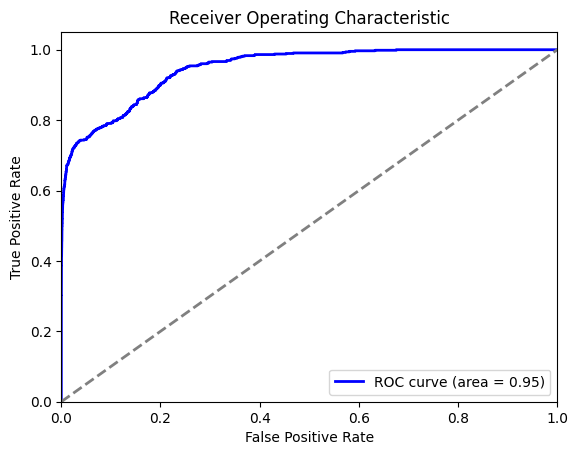

ROC AUC: 0.8206812981695568


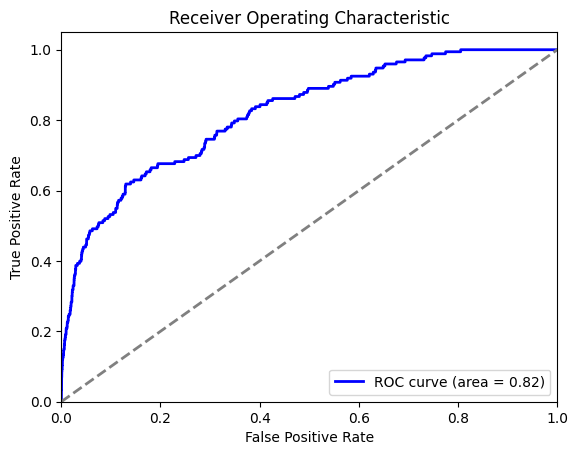

In [62]:
create_roc_auc_curve(rf_model_gs, X_train, y_train)  # Если обучаем на x_train_main и y_train_main
create_roc_auc_curve(rf_model_gs, X_val, y_val)  # То можно не рисовать график, а сразу записывать ответы

In [57]:
X_val.head()

13497    0
13741    0
23588    0
13909    0
26136    0
Name: apply_promo, dtype: int64

In [63]:
X_val.shape, y_val.shape

((5549, 12), (5549,))

In [70]:
predictions = create_predictions(rf_model_gs, X_test, save_name='predictions_rf_grid_search_v3')
# pred_last = pd.read_csv('/content/predictions_rf_grid_search.csv')

   apply_promo
0         0.01
1         0.09
2         0.03
3         0.02
4         0.05


In [66]:
# predictions.shape, pred_last.shape

In [67]:
rf_model_gs.predict_proba(X_test).shape, X_test.shape

((6806, 2), (6806, 12))

In [ ]:
# predictions.head(), pred_last.head()

## Lazy predict

In [ ]:
!pip install lazypredict

In [ ]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_val, y_train, y_val)
models

NameError: name 'X_train' is not defined

## GaussianNB with GridSearchCV

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

# Создание модели GaussianNB
gaussian = GaussianNB()

# Создание 100 значений var_smoothing в логарифмической шкале
# Используем логарифмическое распределение от 1e-10 до 1e-2
log_min = np.log10(1e-10)
log_max = np.log10(1e-2)
log_values = np.linspace(log_min, log_max, 100)
var_smoothing_values = 10 ** log_values

# Параметры для GridSearchCV
param_grid = {
    'var_smoothing': var_smoothing_values # пример значений для подбора
}

# Настройка GridSearchCV
gs_gaussian = GridSearchCV(estimator=gaussian, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

# Обучение GridSearchCV
gs_gaussian.fit(X_train, y_train)

# Печать лучших параметров
print("Best parameters found: ", gs_gaussian.best_params_)

# Лучшая модель
best_model_gauss = gs_gaussian.best_estimator_


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'var_smoothing': 9.999999999999999e-11}


ROC AUC: 0.6932894119591558


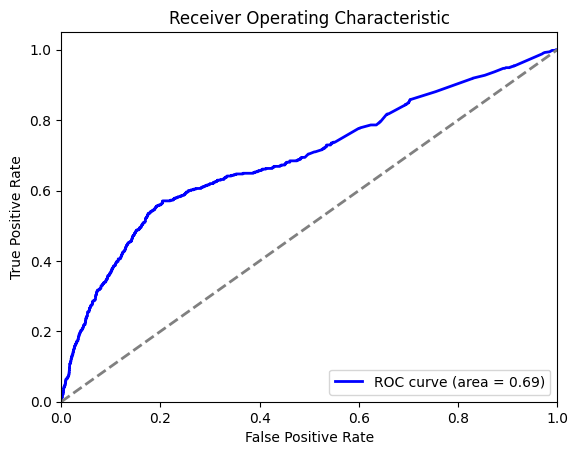

ROC AUC: 0.6932894119591558


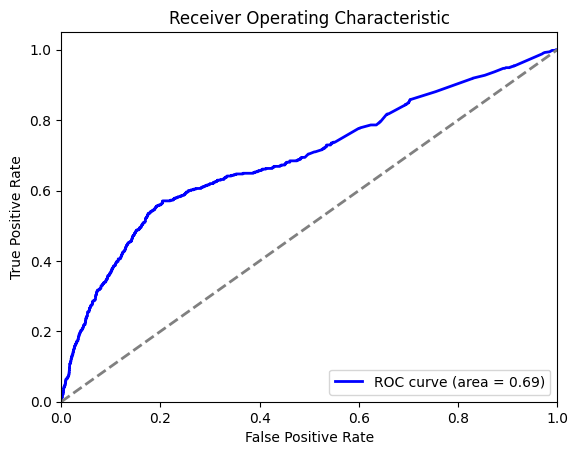

In [ ]:
create_roc_auc_curve(best_model_gauss, X_train, y_train)
create_roc_auc_curve(best_model_gauss, X_val, y_val)

In [ ]:
create_predictions(best_model_gauss, X_test, save_name='predictions_gauss_with_grid_search')

   apply_promo
0         0.01
1         0.93
2         0.00
3         0.00
4         0.05


## Nearest Centroid

In [25]:
from sklearn.neighbors import NearestCentroid
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.extmath import softmax
from sklearn.metrics.pairwise import pairwise_distances


class MyNearestCentroid(NearestCentroid):
  def predict_proba(self, X):
    distances = pairwise_distances(X, self.centroids_, metric=self.metric)
    probs = softmax(distances)
    return probs


# Создание модели NearestCentroid
nearest_centroid = MyNearestCentroid()

# Обучение модели
nearest_centroid.fit(X_train, y_train)

# Получение расстояний до ближайших центроидов
nearest_centroid.predict_proba(X_val)

# Преобразование расстояний в псевдовероятности
# scaler = MinMaxScaler()
# probabilities = scaler.fit_transform(distances.reshape(-1, 1))

NameError: name 'X_val' is not defined

In [ ]:
create_roc_auc_curve(nearest_centroid, X_train, y_train)
create_roc_auc_curve(nearest_centroid, X_val, y_val)

In [ ]:
create_predictions(nearest_centroid, X_test, save_name='predictions_my_nearest_centroid')

## Logistic Regression

In [ ]:
# Обучение модели (например, логистическая регрессия)
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()
lg.fit(X_train, y_train)

## Random Forest Classificator

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Создание и обучение модели RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

In [ ]:
create_roc_auc_curve(rf, X_train, y_train)
create_roc_auc_curve(rf, X_val, y_val)

In [ ]:
create_predictions(rf, X_test, save_name='predictions_rf')

## XGBoost with Optuna


In [ ]:
!pip install optuna xgboost

In [ ]:
# import optuna
# import xgboost as xgb
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import roc_auc_score


# def objective(trial):
#     param = {
#         'objective': 'binary:logistic',
#         'eval_metric': 'auc',
#         'n_estimators': trial.suggest_int('n_estimators', 100, 200),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
#         'max_depth': trial.suggest_int('max_depth', 3, 5),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
#         'subsample': trial.suggest_float('subsample', 0.8, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0)
#     }

#     model = xgb.XGBClassifier(**param)
#     model.fit(X_train, y_train, eval_set=[(X_train, y_train)], early_stopping_rounds=10, verbose=False)

#     y_prob = model.predict_proba(X_val)[:, 1]
#     return roc_auc_score(y_val, y_prob)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# best_params = study.best_params
# print('Best Parameters for XGBClassifier:', best_params)

# # Обучение модели с лучшими параметрами
# best_xgb_model = xgb.XGBClassifier(**best_params)
# best_xgb_model.fit(X_train, y_train)

In [ ]:
create_roc_auc_curve(best_xgb_model, X_train, y_train)
create_roc_auc_curve(best_xgb_model, X_val, y_val)
get_predictions(best_xgb_model, X_test, save_name='predictions_xgb_optuna')